# Importing Packages

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
import imageio

In [2]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
from customMetrics import dice_loss, dice_coef, iou

In [3]:
from gammaTransformation import transform_adaimg

In [4]:
from sklearn.metrics import confusion_matrix

In [5]:
from patchify import patchify, unpatchify

In [6]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Loading Utils Functions

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
def read_image(path):
    src = cv2.imread(path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
    x = cv2.cvtColor(transform_adaimg(rgb), cv2.COLOR_RGB2BGR)
    
    top, bottom = [28] * 2
    left, right = [37,38]
    
    x = cv2.copyMakeBorder(x, top, bottom, left, right, cv2.BORDER_CONSTANT, value= 0)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.float32)
    return ori_x, x

In [9]:
def read_gt(path):
    x = imageio.mimread(path)[0]  ## (128, 128)
    # x = cv2.resize(x, (W, H))
    ori_x = x
    x = x/255.0
    x = x.astype(np.int32)
    return ori_x, x

In [10]:
def load_data(path):
    x = sorted(glob(os.path.join(path, "images", "*.tif")))
    y = sorted(glob(os.path.join(path, "1st_manual", "*.gif")))
    return x, y

In [11]:
def save_results(ori_x, ori_y, y_pred, save_image_path):
    line = np.ones((H, 10, 3)) * 255

    ori_y = np.expand_dims(ori_y, axis=-1)
    ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255

    cat_images = np.concatenate([ori_y, line, y_pred], axis=1)
    
    cv2.imwrite(save_image_path, cat_images)

In [12]:
def save_tests(y_pred, save_image_path):

    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) * 255


    cv2.imwrite(save_image_path, y_pred)

In [13]:
def get_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    sen = tp/(tp+fn)
    spe = tn/(tn+fp) 
    return sen, spe

# Setting The Environment

In [14]:
H = 584
W = 565

In [15]:
data_path = "D:\\Data sets\\DRIVE"

In [16]:
""" Save the results in this folder """
create_dir("results")

In [17]:
""" Load the model """
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model = tf.keras.models.load_model("modelDir/model128_2.h5")


In [18]:
""" Load the dataset """
traindataset_path = os.path.join(data_path,"training")
train_x, train_y = load_data(traindataset_path)

testdataset_path = os.path.join(data_path,"test")
test_x, test_y = load_data(testdataset_path)

In [19]:
testdataset_path,len(test_x)

('D:\\Data sets\\DRIVE\\test', 20)

In [20]:
traindataset_path,len(train_x)

('D:\\Data sets\\DRIVE\\training', 20)

In [21]:
from matplotlib import pyplot as plt

# Training Results

In [26]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(train_x, train_y), total=len(train_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Train.png"
    print(save_image_path)

#     save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

21_training
(640, 640, 3) (584, 565)
(584, 565)
results\21_trainingTrain.png


  5%|███████▎                                                                                                                                         | 1/20 [00:02<00:43,  2.28s/it]

22_training
(640, 640, 3) (584, 565)
(584, 565)
results\22_trainingTrain.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:04<00:39,  2.17s/it]

23_training
(640, 640, 3) (584, 565)
(584, 565)
results\23_trainingTrain.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:06<00:36,  2.15s/it]

24_training
(640, 640, 3) (584, 565)
(584, 565)
results\24_trainingTrain.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:08<00:33,  2.12s/it]

25_training
(640, 640, 3) (584, 565)
(584, 565)
results\25_trainingTrain.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:10<00:32,  2.14s/it]

26_training
(640, 640, 3) (584, 565)
(584, 565)
results\26_trainingTrain.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:12<00:29,  2.13s/it]

27_training
(640, 640, 3) (584, 565)
(584, 565)
results\27_trainingTrain.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:15<00:28,  2.19s/it]

28_training
(640, 640, 3) (584, 565)
(584, 565)
results\28_trainingTrain.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [00:17<00:25,  2.16s/it]

29_training
(640, 640, 3) (584, 565)
(584, 565)
results\29_trainingTrain.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [00:19<00:23,  2.13s/it]

30_training
(640, 640, 3) (584, 565)
(584, 565)
results\30_trainingTrain.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [00:21<00:21,  2.12s/it]

31_training
(640, 640, 3) (584, 565)
(584, 565)
results\31_trainingTrain.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [00:23<00:19,  2.12s/it]

32_training
(640, 640, 3) (584, 565)
(584, 565)
results\32_trainingTrain.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [00:25<00:16,  2.12s/it]

33_training
(640, 640, 3) (584, 565)
(584, 565)
results\33_trainingTrain.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [00:27<00:14,  2.14s/it]

34_training
(640, 640, 3) (584, 565)
(584, 565)
results\34_trainingTrain.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [00:30<00:13,  2.19s/it]

35_training
(640, 640, 3) (584, 565)
(584, 565)
results\35_trainingTrain.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [00:32<00:10,  2.17s/it]

36_training
(640, 640, 3) (584, 565)
(584, 565)
results\36_trainingTrain.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [00:34<00:08,  2.16s/it]

37_training
(640, 640, 3) (584, 565)
(584, 565)
results\37_trainingTrain.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [00:36<00:06,  2.14s/it]

38_training
(640, 640, 3) (584, 565)
(584, 565)
results\38_trainingTrain.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [00:38<00:04,  2.14s/it]

39_training
(640, 640, 3) (584, 565)
(584, 565)
results\39_trainingTrain.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [00:40<00:02,  2.13s/it]

40_training
(640, 640, 3) (584, 565)
(584, 565)
results\40_trainingTrain.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:42<00:00,  2.14s/it]


In [27]:
SCORE

[['21_training',
  0.9696084373863498,
  0.7869012707722386,
  0.6486704270749396,
  0.7508719279746938,
  0.8265625,
  0.7508719279746938,
  0.9872748950219782],
 ['22_training',
  0.9699993938659232,
  0.8159524030863624,
  0.6891212863513598,
  0.7361199637693314,
  0.9152068735402069,
  0.7361199637693314,
  0.9932267425395884],
 ['23_training',
  0.9740210934658746,
  0.7814714730026002,
  0.6413239047658897,
  0.7055655296229802,
  0.8756784551219791,
  0.7055655296229802,
  0.9929404970850352],
 ['24_training',
  0.9619802400290944,
  0.8119331384453939,
  0.6834069400630914,
  0.708362761254545,
  0.950976260710774,
  0.708362761254545,
  0.9952147697707819],
 ['25_training',
  0.9474027154806643,
  0.6424082582984774,
  0.4731969402622632,
  0.4922479396255013,
  0.9243951612903226,
  0.4922479396255013,
  0.9957256504554277],
 ['26_training',
  0.9638168262819736,
  0.7458002427236146,
  0.594642311479306,
  0.6351865955826352,
  0.9030628029287409,
  0.6351865955826352,
  0.

In [31]:

stat_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
stat_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,21_training,0.969608,0.786901,0.648670,0.750872,0.826562,0.750872,0.987275
1,22_training,0.969999,0.815952,0.689121,0.736120,0.915207,0.736120,0.993227
2,23_training,0.974021,0.781471,0.641324,0.705566,0.875678,0.705566,0.992940
3,24_training,0.961980,0.811933,0.683407,0.708363,0.950976,0.708363,0.995215
4,25_training,0.947403,0.642408,0.473197,0.492248,0.924395,0.492248,0.995726
5,26_training,0.963817,0.745800,0.594642,0.635187,0.903063,0.635187,0.993783
6,27_training,0.973603,0.841203,0.725928,0.793520,0.894984,0.793520,0.991003
7,28_training,0.975052,0.864783,0.761778,0.816805,0.918749,0.816805,0.992181
8,29_training,0.960250,0.738715,0.585684,0.668120,0.825990,0.668120,0.987075
9,30_training,0.961195,0.692256,0.529351,0.556367,0.915978,0.556367,0.995656


In [28]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")


Accuracy: 0.96896
F1: 0.80006
Jaccard: 0.67075
Recall: 0.73862
Precision: 0.88290
Sensitivity: 0.73862
Specificity: 0.99065


In [37]:
rows = ["Accuracy", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"]

In [39]:
df = pd.DataFrame(
    {'Metrics': rows,
     'Model_128_2': score,
    })
df

,Metrics,Model_128_2
0,Accuracy,0.968957
1,F1,0.800063
2,Jaccard,0.670754
3,Recall,0.738623
4,Precision,0.882897
5,Sensitivity,0.738623
6,Specificity,0.990655


In [40]:
""" Saving """
df.to_csv("results/score.csv", index=False)

In [42]:
import seaborn as sns

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

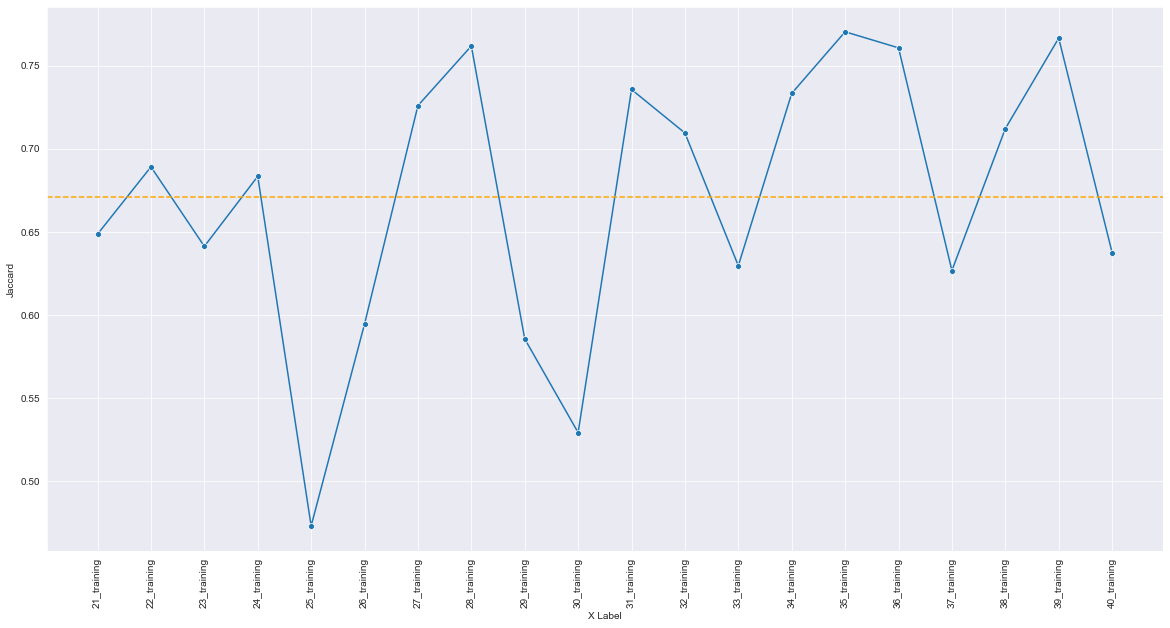

In [45]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=stat_df, x="Image", y="Jaccard", marker = "o")
ax.axhline(stat_df["Jaccard"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "Jaccard")
plt.setp(ax.get_xticklabels(), rotation=90)


# Test Results

In [46]:
""" Make the prediction and calculate the metrics values """
SCORE = []

for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
    
    """ Extracting name """
    name = x.split("\\")[-1].split(".")[0]
    print(name)
    """ Read the image and mask """
    ori_x, x = read_image(x)
    ori_y, y = read_gt(y)
    
    print(ori_x.shape, ori_y.shape)
    
    patches_img = patchify(x, (128, 128,3), step=128)
    
    pred_patches = []
    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):        
            single_patch_img = patches_img[i,j,:,:][0]
#             print(single_patch_img.shape)
            
            """ Prediction """
            y_pred = model.predict(np.expand_dims(single_patch_img, axis=0))[0]
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = np.squeeze(y_pred, axis=-1)
            
            pred_patches.append(y_pred)
    pred_patches_reshaped = np.reshape(pred_patches, (5, 5, 128,128) )
    reconstructed_image = unpatchify(pred_patches_reshaped, (640,640))
    
    final_y_pred = reconstructed_image[28:-28,37:-38]
    print(final_y_pred.shape)
#     plt.imshow(final_y_pred, cmap='gray')
    
    
    """ Saving the images """
    save_image_path = f"results\\{name}Test.png"
    print(save_image_path)

#     save_results(ori_x, ori_y, final_y_pred, save_image_path)

    """ Flatten the array """
    y = y.flatten()
    final_y_pred = final_y_pred.flatten()

    """ Calculate the metrics """
    acc_value = accuracy_score(y, final_y_pred)
    f1_value = f1_score(y, final_y_pred, labels=[0, 1], average="binary")
    jac_value = jaccard_score(y, final_y_pred, labels=[0, 1], average="binary")
    recall_value = recall_score(y, final_y_pred, labels=[0, 1], average="binary")
    precision_value = precision_score(y, final_y_pred, labels=[0, 1], average="binary")
    
    cm = confusion_matrix(y, final_y_pred)
    sensitivity, specificity = get_metrics(cm)
    
    SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value, sensitivity, specificity])

  0%|                                                                                                                                                         | 0/20 [00:00<?, ?it/s]

01_test
(640, 640, 3) (584, 565)
(584, 565)
results\01_testTest.png


  5%|███████▎                                                                                                                                         | 1/20 [00:27<08:41, 27.43s/it]

02_test
(640, 640, 3) (584, 565)
(584, 565)
results\02_testTest.png


 10%|██████████████▌                                                                                                                                  | 2/20 [00:44<06:22, 21.25s/it]

03_test
(640, 640, 3) (584, 565)
(584, 565)
results\03_testTest.png


 15%|█████████████████████▊                                                                                                                           | 3/20 [00:47<03:38, 12.88s/it]

04_test
(640, 640, 3) (584, 565)
(584, 565)
results\04_testTest.png


 20%|█████████████████████████████                                                                                                                    | 4/20 [00:50<02:23,  8.94s/it]

05_test
(640, 640, 3) (584, 565)
(584, 565)
results\05_testTest.png


 25%|████████████████████████████████████▎                                                                                                            | 5/20 [00:52<01:40,  6.69s/it]

06_test
(640, 640, 3) (584, 565)
(584, 565)
results\06_testTest.png


 30%|███████████████████████████████████████████▌                                                                                                     | 6/20 [00:55<01:14,  5.32s/it]

07_test
(640, 640, 3) (584, 565)
(584, 565)
results\07_testTest.png


 35%|██████████████████████████████████████████████████▊                                                                                              | 7/20 [00:58<00:57,  4.43s/it]

08_test
(640, 640, 3) (584, 565)
(584, 565)
results\08_testTest.png


 40%|██████████████████████████████████████████████████████████                                                                                       | 8/20 [01:00<00:46,  3.84s/it]

09_test
(640, 640, 3) (584, 565)
(584, 565)
results\09_testTest.png


 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 9/20 [01:03<00:37,  3.44s/it]

10_test
(640, 640, 3) (584, 565)
(584, 565)
results\10_testTest.png


 50%|████████████████████████████████████████████████████████████████████████                                                                        | 10/20 [01:05<00:31,  3.20s/it]

11_test
(640, 640, 3) (584, 565)
(584, 565)
results\11_testTest.png


 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 11/20 [01:08<00:27,  3.01s/it]

12_test
(640, 640, 3) (584, 565)
(584, 565)
results\12_testTest.png


 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 12/20 [01:11<00:24,  3.02s/it]

13_test
(640, 640, 3) (584, 565)
(584, 565)
results\13_testTest.png


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 13/20 [01:14<00:20,  2.88s/it]

14_test
(640, 640, 3) (584, 565)
(584, 565)
results\14_testTest.png


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 14/20 [01:16<00:16,  2.77s/it]

15_test
(640, 640, 3) (584, 565)
(584, 565)
results\15_testTest.png


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 15/20 [01:19<00:13,  2.69s/it]

16_test
(640, 640, 3) (584, 565)
(584, 565)
results\16_testTest.png


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 16/20 [01:21<00:10,  2.64s/it]

17_test
(640, 640, 3) (584, 565)
(584, 565)
results\17_testTest.png


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 17/20 [01:24<00:07,  2.61s/it]

18_test
(640, 640, 3) (584, 565)
(584, 565)
results\18_testTest.png


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 18/20 [01:26<00:05,  2.60s/it]

19_test
(640, 640, 3) (584, 565)
(584, 565)
results\19_testTest.png


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 19/20 [01:29<00:02,  2.59s/it]

20_test
(640, 640, 3) (584, 565)
(584, 565)
results\20_testTest.png


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:31<00:00,  4.59s/it]


In [48]:
score = [s[1:] for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy: {score[0]:0.5f}")
print(f"F1: {score[1]:0.5f}")
print(f"Jaccard: {score[2]:0.5f}")
print(f"Recall: {score[3]:0.5f}")
print(f"Precision: {score[4]:0.5f}")
print(f"Sensitivity: {score[5]:0.5f}")
print(f"Specificity: {score[6]:0.5f}")

Accuracy: 0.96035
F1: 0.74404
Jaccard: 0.59393
Recall: 0.66793
Precision: 0.85099
Sensitivity: 0.66793
Specificity: 0.98853


In [50]:
test_df = pd.DataFrame(SCORE, columns=["Image", "Acc", "F1", "Jaccard", "Recall", "Precision", "Sensitivity", "Specificity"])
test_df

,Image,Acc,F1,Jaccard,Recall,Precision,Sensitivity,Specificity
0,01_test,0.961313,0.778281,0.637038,0.761005,0.796360,0.761005,0.980936
1,02_test,0.961841,0.791784,0.655334,0.708494,0.897268,0.708494,0.990745
2,03_test,0.948533,0.676657,0.511323,0.540206,0.905334,0.540206,0.993746
3,04_test,0.963938,0.783019,0.643412,0.707320,0.876863,0.707320,0.989937
4,05_test,0.954107,0.691369,0.528314,0.548687,0.934336,0.548687,0.996014
5,06_test,0.955070,0.725681,0.569466,0.610568,0.894286,0.610568,0.992217
6,07_test,0.960592,0.763869,0.617952,0.697533,0.844150,0.697533,0.987048
7,08_test,0.955582,0.688885,0.525419,0.571559,0.866820,0.571559,0.991733
8,09_test,0.957419,0.673969,0.508260,0.543061,0.888033,0.543061,0.993961
9,10_test,0.963008,0.753822,0.604907,0.688172,0.833318,0.688172,0.987655


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

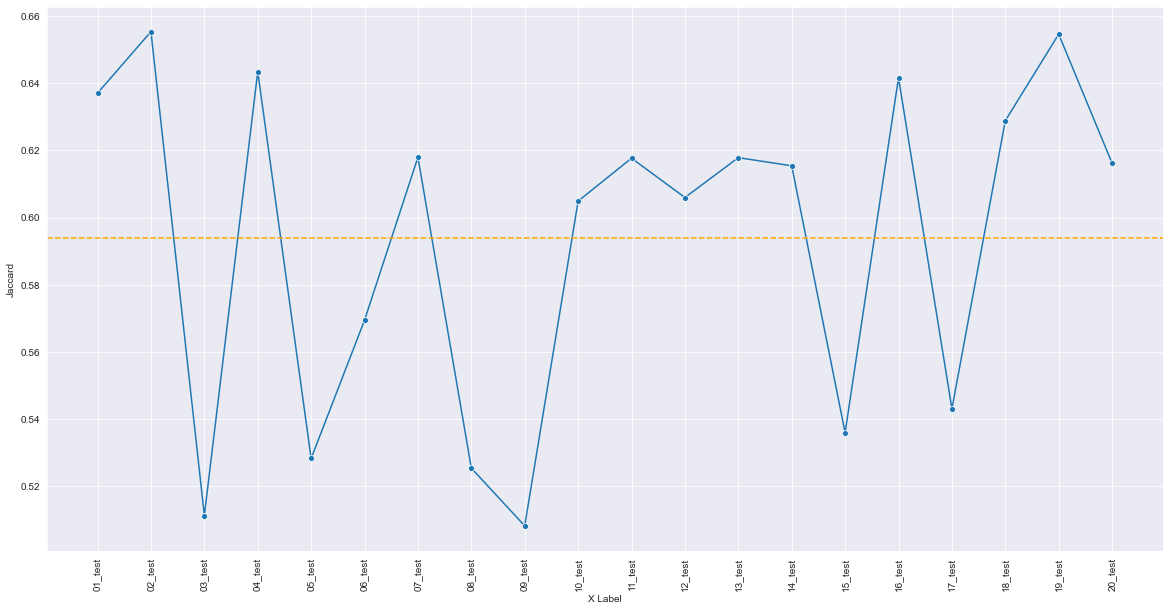

In [51]:
plt.figure(figsize=(20, 10))
sns.set_style("darkgrid")
ax = sns.lineplot(data=test_df, x="Image", y="Jaccard", marker = "o")
ax.axhline(test_df["Jaccard"].mean(), color="orange", linestyle="--")
ax.set(xlabel="X Label", ylabel = "Jaccard")
plt.setp(ax.get_xticklabels(), rotation=90)


In [52]:
df = pd.DataFrame(
    {'Metrics': rows,
     'Model_128_2': score,
    })
df

,Metrics,Model_128_2
0,Accuracy,0.960354
1,F1,0.744036
2,Jaccard,0.593931
3,Recall,0.667927
4,Precision,0.850988
5,Sensitivity,0.667927
6,Specificity,0.988535


In [53]:
""" Saving """
df.to_csv("results/test.csv", index=False)